<a href="https://colab.research.google.com/github/ImanNoferesti/Emotion_AI_Python/blob/main/1_Key_Facial_Detection_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Import Required Libraries and Load Datasets

In [1]:
# Mount the drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/EmotionAI/

/content/drive/MyDrive/EmotionAI


In [3]:
# Import the necessary packages
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [4]:
# Load facial key points data
key_facial_df = pd.read_csv('data.csv')

# Get the concise summary of the dataFrame.
key_facial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [5]:
# Check for existance of null values
key_facial_df.isnull().sum()

,0
left_eye_center_x,0
left_eye_center_y,0
right_eye_center_x,0
right_eye_center_y,0
left_eye_inner_corner_x,0
left_eye_inner_corner_y,0
left_eye_outer_corner_x,0
left_eye_outer_corner_y,0
right_eye_inner_corner_x,0
right_eye_inner_corner_y,0


In [6]:
key_facial_df['Image'].shape

(2140,)

Since values for the image are given as space-separated string, separate the values using ' ' as separator.

Then, convert this into numpy array using `np.fromstring()` and `reshape()` the obtained 1D array into 2D array of shape (96,96)

In [7]:
key_facial_df['Image'] = key_facial_df['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(96,96))

In [8]:
# Get the Image shape
key_facial_df['Image'][0].shape

(96, 96)

In [9]:
# Get the average, min, and max of a variable
key_facial_df['right_eye_center_x'].describe()

,right_eye_center_x
count,2140.000000
mean,29.640269
std,2.051575
min,18.922611
25%,28.472224
50%,29.655440
75%,30.858673
max,42.495172


### Step 2: Generate Image Visualization

Plot a random image from the dataset along with facial keypoints.

The image data is retrieved from `df['Image']` and shown using `plt.imshow()`. The facial keypoints consist of 15 pairs of x and y coordinates.

Since x-coordinates are located in even columns (e.g., 0, 2, 4, ...) and y-coordinates are in odd columns (e.g., 1, 3, 5, ...), their values are accessed using the `.loc` command, which fetches the coordinates for the image based on the corresponding column.

<ipython-input-10-345093249154>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')


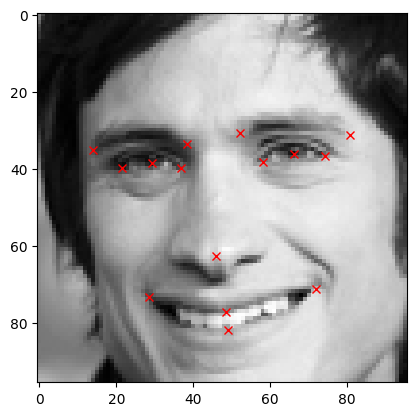

In [10]:
# Pick a random number
i = np.random.randint(1,len(key_facial_df))

# Show the image
plt.imshow(key_facial_df['Image'][i], cmap='gray')

# Add marks to the image
for j in range(1,31,2):
  # plot x and y coordinates
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')

<ipython-input-11-a59ad882f134>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')


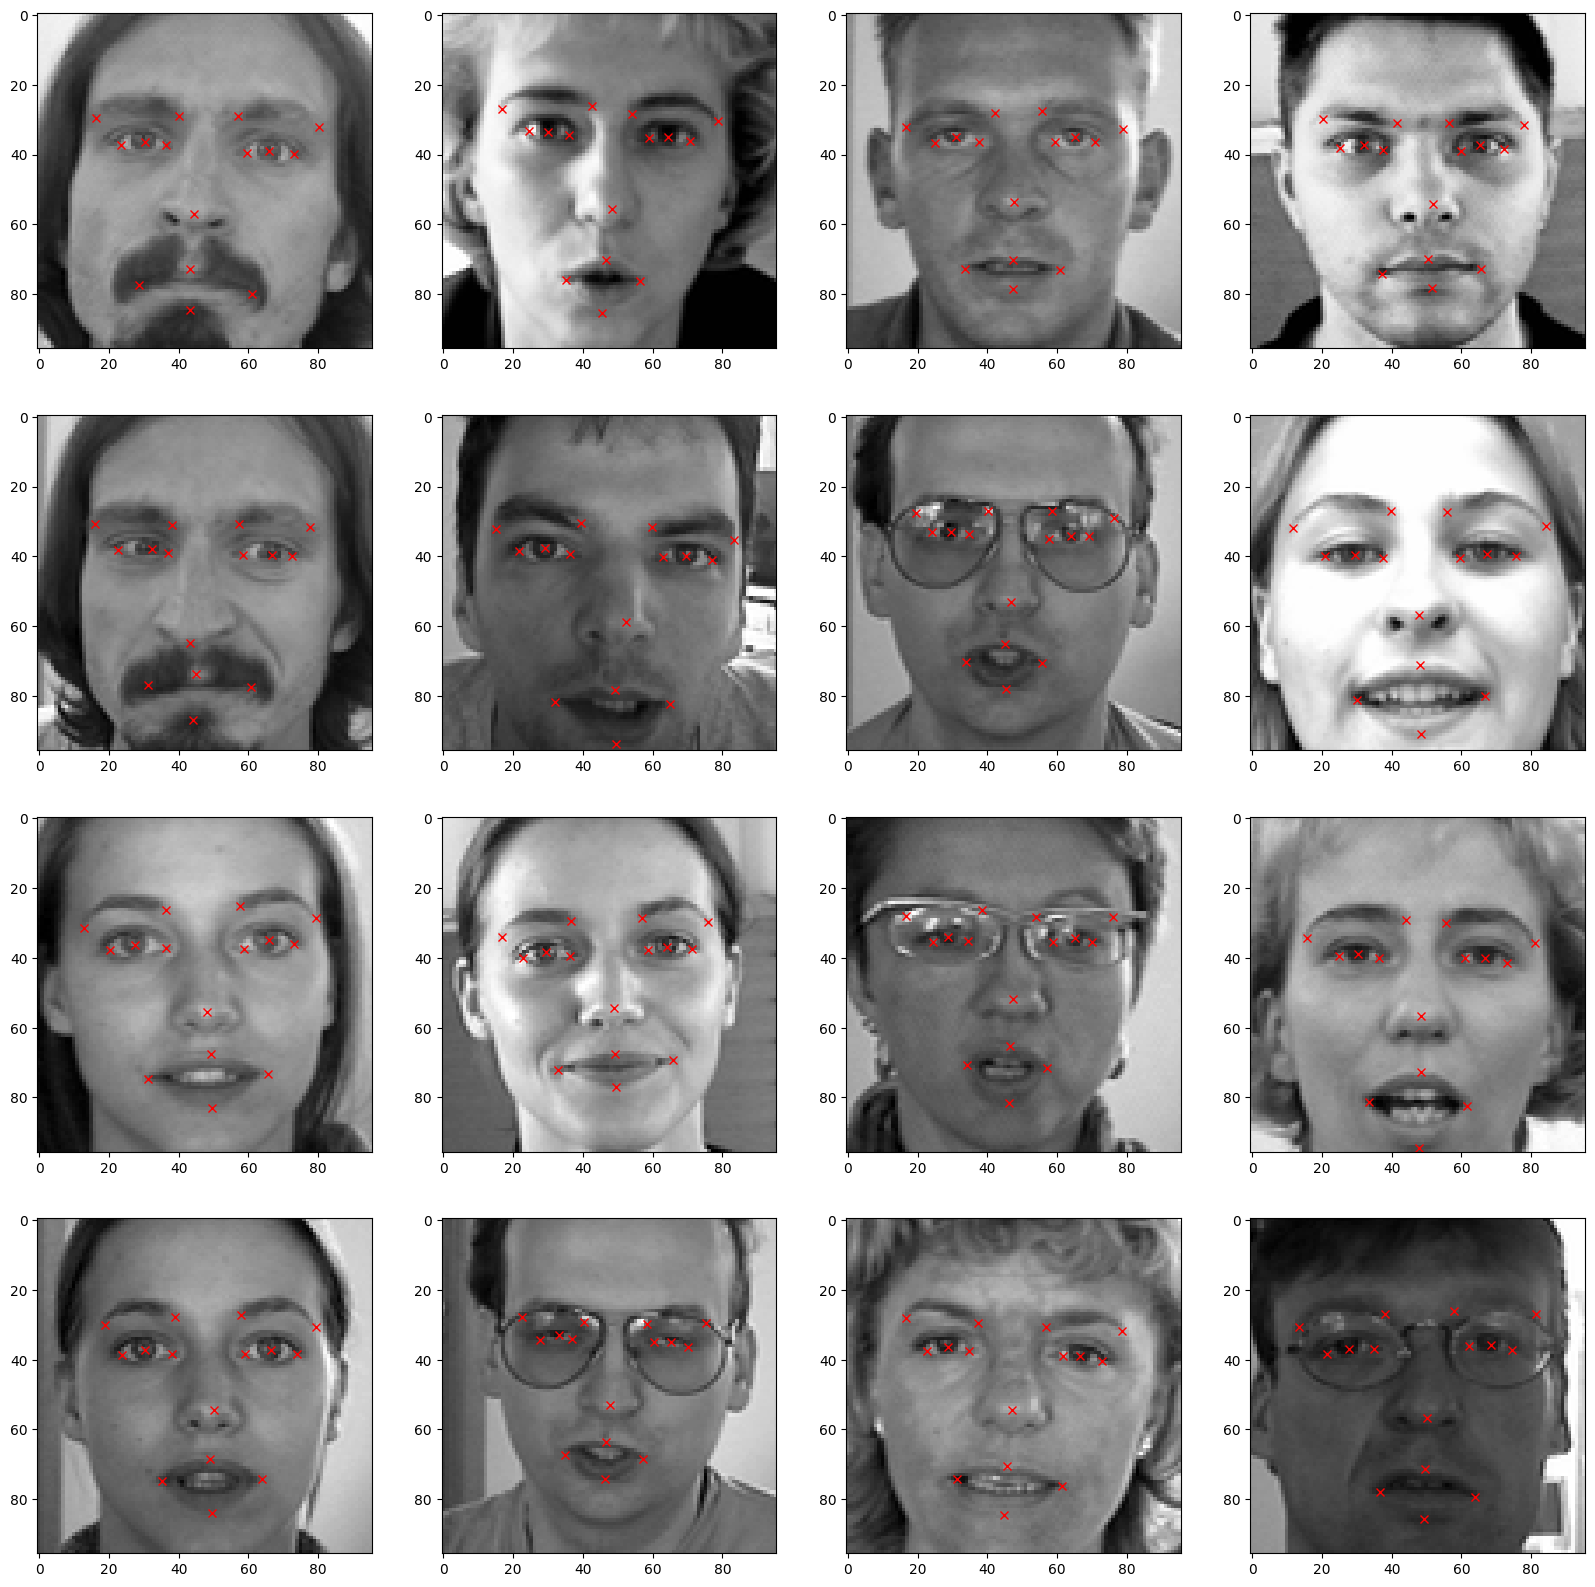

In [11]:
# Display more images in a grid format
fig = plt.figure(figsize=(20,20))

img_quantities = 16

for i in range(img_quantities):
  # subplot with 4 rows, 4 columns, and the index i+1 is used to specify the position of the subplot within a grid layout.
  ax = fig.add_subplot(4,4,i+1)
  image = plt.imshow(key_facial_df['Image'][i], cmap='gray')
  for j in range(1,31,2):
    plt.plot(key_facial_df.loc[i][j-1], key_facial_df.loc[i][j], 'rx')

<ipython-input-12-59bf9fad74d8>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[r][j-1], key_facial_df.loc[r][j], 'rx')


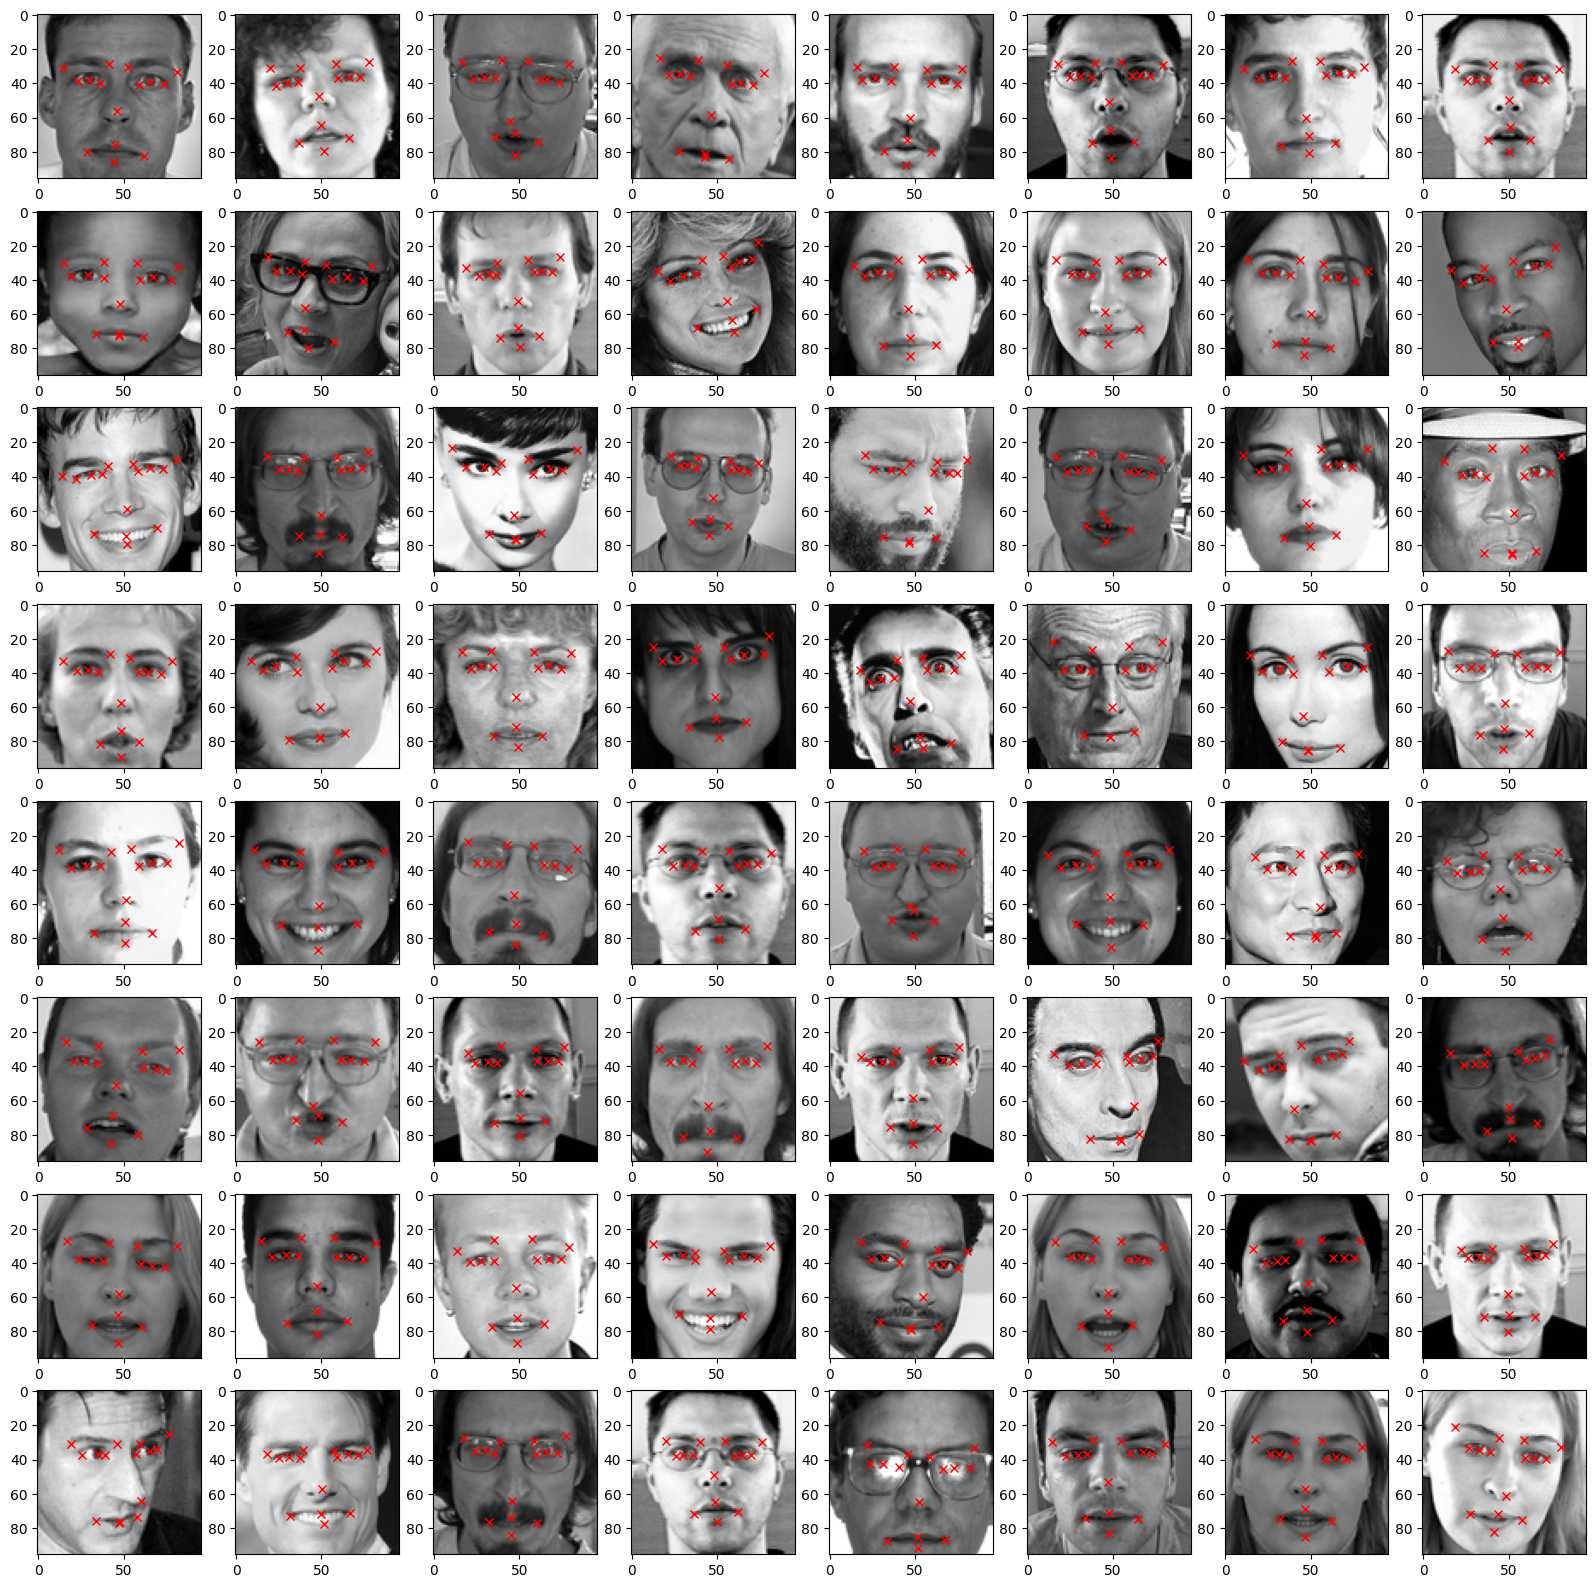

In [12]:
# Perform a sanity check on the data by randomly visualizing 64 new images along with their corresponding key points.

fig = plt.figure(figsize=(20,20))

for i in range(64):
  r = np.random.randint(1,len(key_facial_df))
  ax = plt.subplot(8,8,i+1)
  image = plt.imshow(key_facial_df['Image'][r], cmap='gray')
  for j in range(1,31,2):
    plt.plot(key_facial_df.loc[r][j-1], key_facial_df.loc[r][j], 'rx')



### Step 3: Perform Image Augmentation

In [13]:
# Create a new copy of the original dataframe
import copy
key_facial_df_copy = copy.copy(key_facial_df)

In [14]:
# Get all columns but the Image column
columns = key_facial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [15]:
# Horizontal Flip: Flip the image along y-axis
key_facial_df_copy['Image'] = key_facial_df_copy['Image'].apply(lambda x: np.flip(x, axis=1))

# Since we're flipping horizontally, y-coordinate values remains the same
# Only x-coordinates would change. To fix, subtract the initial x-coordinates from the width of the image(96px)

for i in range(len(columns)):
  if i % 2 == 0:
    key_facial_df_copy[columns[i]] = key_facial_df_copy[columns[i]].apply(lambda x: 96.0 - float(x))


<ipython-input-16-b7553016f8be>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df.loc[0][i-1], key_facial_df.loc[0][i], 'rx')


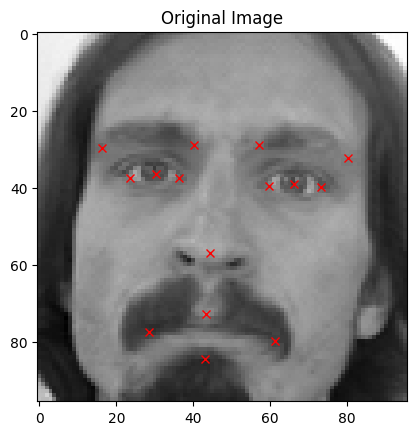

In [16]:
# Display an original image
plt.imshow(key_facial_df['Image'][0], cmap='gray')
plt.title("Original Image")
for i in range(1,31,2):
  plt.plot(key_facial_df.loc[0][i-1], key_facial_df.loc[0][i], 'rx')

<ipython-input-17-fe16cc0045f4>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')


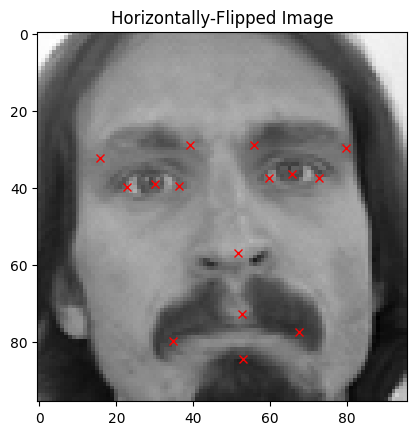

In [17]:
# Display the horizontal-flipped image
plt.imshow(key_facial_df_copy['Image'][0], cmap='gray')
plt.title("Horizontally-Flipped Image")
for i in range(1,31,2):
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')

In [18]:
# Concatenate the original dataframe with the augmented one
augmented_df = np.concatenate((key_facial_df, key_facial_df_copy))

augmented_df.shape

(4280, 31)

In [19]:
# Vertical Flip: Flip the image along x-axis
key_facial_df_copy = copy.copy(key_facial_df)

key_facial_df_copy['Image'] = key_facial_df_copy['Image'].apply(lambda x: np.flip(x, axis=0))
for i in range(len(columns)):
  if i % 2 != 0:
    key_facial_df_copy[columns[i]] = key_facial_df_copy[columns[i]].apply(lambda x: (96.0 - float(x)))

<ipython-input-20-3c5e762b8a85>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')


(6420, 31)

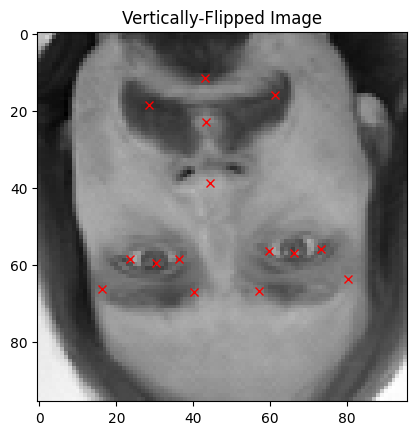

In [20]:
# Display the vertical-flipped image
plt.imshow(key_facial_df_copy['Image'][0], cmap='gray')
plt.title("Vertically-Flipped Image")
for i in range(1,31,2):
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')

augmented_df = np.concatenate((augmented_df,key_facial_df_copy))
augmented_df.shape

In [21]:
# Brightness Augmentation: Randomly increase the brightness of the images
# Multiply pixel values by random values between 1.5 and 2 to increase the brightness of the image
# Clip the value between 0-255

import random

key_facial_df_copy = copy.copy(key_facial_df)
key_facial_df_copy['Image'] = key_facial_df_copy['Image'].apply(lambda x: np.clip(random.uniform(1.5,2)*x, 0.0,255.0))

augmented_df = np.concatenate((augmented_df, key_facial_df_copy))
augmented_df.shape

(8560, 31)

<ipython-input-22-e5c4773cd294>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')


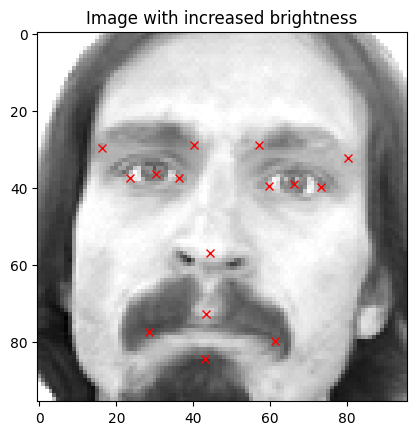

In [22]:
# Show the image with increased brightness
plt.imshow(key_facial_df_copy['Image'][0], cmap='gray')
plt.title("Image with increased brightness")
for i in range(1,31,2):
  plt.plot(key_facial_df_copy.loc[0][i-1], key_facial_df_copy.loc[0][i], 'rx')

### Step 4: Data Normalization and Data Prepration

In [23]:
# Get the value of images which is present in the last column
img = augmented_df[:,-1]

# Normalize the images values
img = img / 255.0

# Create an empty array of shape(x, 96, 96, 1) to feed the model
X = np.empty((len(img), 96, 96, 1))

# Iterate through the img list and add image values to the empty array after expanding its dimensions from (96,96) to (96,96,1)
for i in range(len(img)):
  X[i, ] = np.expand_dims(img[i], axis=2)

# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [24]:
# Get the values of the x and y coordinates that will be used as target variables.
y = augmented_df[:,:-1]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [25]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Step 5: Build Deep Residual Neural Netwrok To Perfom Key Facial Detection Model (Using Keras and TensorFlow)

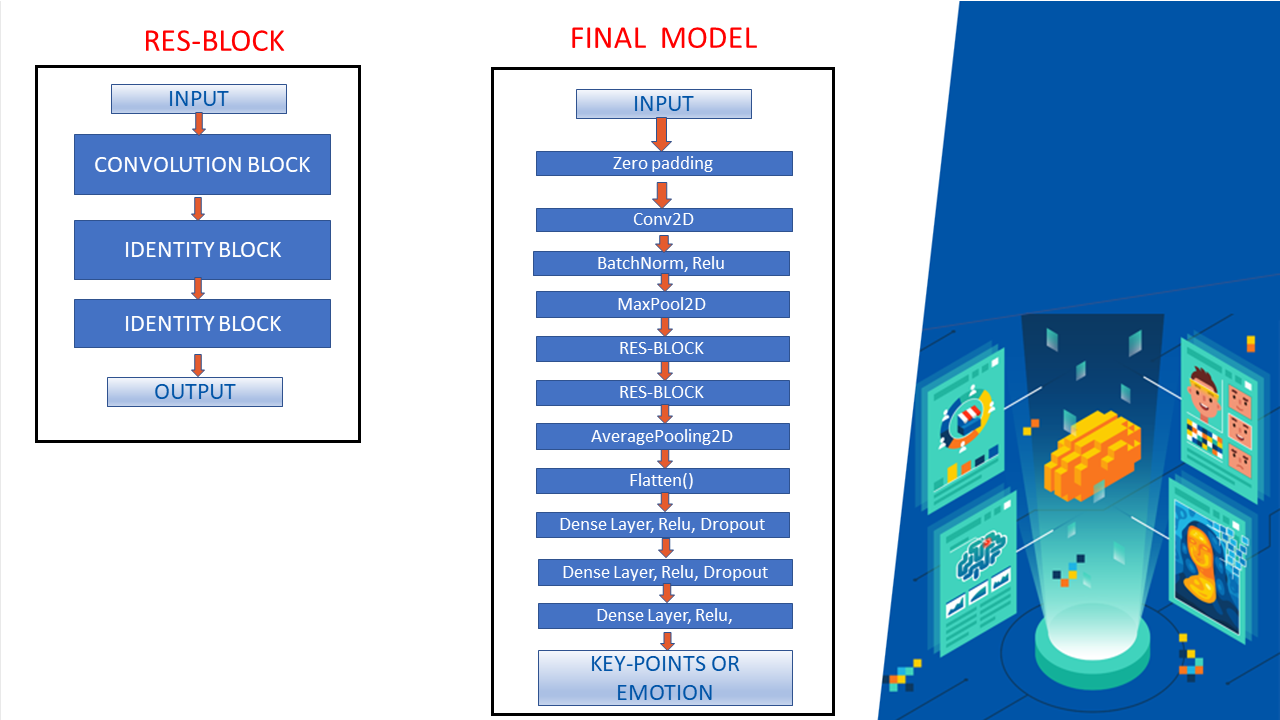

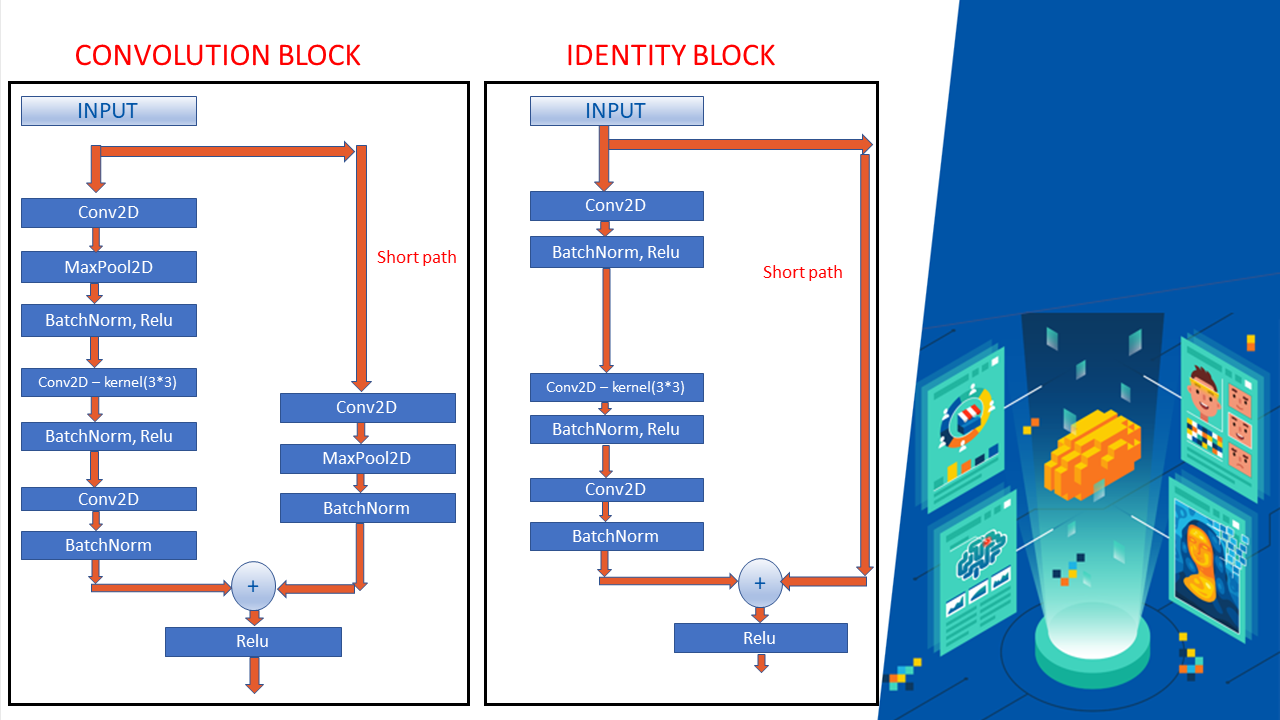

In [26]:
# Building RES-Block

def res_block(X, filter, stage):

  # Convolutional Block
  X_copy = X
  f1,f2,f3 = filter

  # Main Path

  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
            # (1,1): This defines the size of the convolution filter. A filter of size 1x1 means that the convolution operation will consider one pixel at a time.
            # strides=(1,1): Strides determine how the convolution filter moves across the input image. A stride of (1,1) means the filter moves one pixel at a time both horizontally and vertically.
            # name='res_' + str(stage) + '_conv_a': This sets the name of the layer. The name is dynamically generated based on the stage variable and is useful for identifying layers in complex models (e.g., in ResNet architectures).
            # kernel_initializer=glorot_uniform(seed=0): This specifies how the weights (kernels) are initialized. glorot_uniform is a method for initializing the weights with values drawn from a uniform distribution, which helps in keeping the gradient flow stable during training. The seed=0 ensures reproducibility of the random initialization.

  X = MaxPool2D((2,2))(X)
            # MaxPool2D((2,2)): This applies a max pooling operation over the input tensor X to downsample it. Max pooling reduces the spatial dimensions (height and width) of the input while keeping the most important features.
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
            # axis=3: This indicates which axis will be normalized. In this case, axis=3 refers to the channel axis in a 4D input tensor of shape (batch_size, height, width, channels), which is common in image data. Batch normalization will be applied across the channels.
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)


  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 1
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Identity Block 2
  X_copy = X


  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # ADD
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [27]:
# Building Final Model

from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

# Input tensor shape
input_shape = (96, 96, 1)
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3,3))(X_input)

# 1 - stage
X = Conv2D(64, (7,7), strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3), strides= (2,2))(X)

# 2 - stage (Assumes res_block is correctly implemented)
X = res_block(X, filter= [64,64,256], stage= 2)

# 3 - stage
X = res_block(X, filter= [128,128,512], stage= 3)

# Average Pooling
X = AveragePooling2D((2,2), name = 'Average_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(4096, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation = 'relu')(X)
X = Dropout(0.1)(X)

# Output layer (change activation depending on your task)
X = Dense(30, activation = 'relu')(X)  # 'linear' for regression, change to 'softmax' or 'sigmoid' for classification

# Create model
model_1_facialKeyPoints = Model(inputs= X_input, outputs = X)

# Summary of the model
model_1_facialKeyPoints.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 102, 102, 1)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 48, 48, 64)     │          3,200 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 48, 48, 64)     │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 48, 48, 64)     │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 23, 23, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_a (Conv2D)     │ (None, 23, 23, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 11, 11, 64)     │              0 │ res_2_conv_a[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_a               │ (None, 11, 11, 64)     │            256 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 11, 11, 64)     │              0 │ bn_2_conv_a[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_b (Conv2D)     │ (None, 11, 11, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_2_conv_b               │ (None, 11, 11, 64)     │            256 │ res_2_conv_b[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 11, 11, 64)     │              0 │ bn_2_conv_b[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_copy (Conv2D)  │ (None, 23, 23, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res_2_conv_c (Conv2D)     │ (None, 11, 11, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 11, 11, 256)    │              0 │ res_2_conv_copy[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 18,016,286 (68.73 MB)

 Trainable params: 18,007,710 (68.69 MB)

 Non-trainable params: 8,576 (33.50 KB)

### Step 6: Compile and Train Key Facial Points Detection (Deep Learning Model)

In [28]:
# This line creates an Adam optimizer in TensorFlow, which is a commonly used optimizer for training machine learning models.
#   beta_1=0.9: This is the exponential decay rate for the first moment estimates (mean of past gradients).
#   beta_2=0.999: The exponential decay rate for the second moment estimates (uncentered variance of past gradients).
#   amsgrad=False: Whether or not to use the AMSGrad variant of the Adam optimizer, which can improve convergence in some cases. If set to True, AMSGrad is used.
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=adam, metrics=['accuracy'])

In [29]:
# This line defines a model checkpoint in Keras. It saves the model's weights to the file FacialKeyPoints_weights.hdf5 and
# will only save the best model (based on validation performance). verbose=1 provides logs when saving.
checkpointer = ModelCheckpoint(filepath="FacialKeyPoints_weights.keras", verbose=1, save_best_only=True)

In [30]:
# This line trains a model called model_1_facialKeyPoints using the training data (X_train, y_train).
#   batch_size=32: The model processes 32 samples at a time before updating.
#   epochs=2: The model will go through the entire dataset twice.
#   validation_split=0.05: 5% of the training data is used for validation to monitor model performance during training.
#   callbacks=[checkpointer]: The checkpointer callback saves the best model during training.
history = model_1_facialKeyPoints.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.05, callbacks=[checkpointer])

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3349 - loss: 607.3734
Epoch 1: val_loss improved from inf to 604.40955, saving model to FacialKeyPoints_weights.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 60s 138ms/step - accuracy: 0.3357 - loss: 606.0175 - val_accuracy: 0.3860 - val_loss: 604.4095
Epoch 2/50
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6714 - loss: 84.6723
Epoch 2: val_loss improved from 604.40955 to 187.21497, saving model to FacialKeyPoints_weights.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.6714 - loss: 84.6052 - val_accuracy: 0.7435 - val_loss: 187.2150
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6700 - loss: 50.4518
Epoch 3: val_loss improved from 187.21497 to 70.26789, saving model to FacialKeyPoints_weights.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6700 - loss: 50.4535 - val_accuracy: 0.6917 - val_loss: 70.2679
Epoch 4/50
228/229 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.666

In [31]:
# Save  the model architecture as json file for future uses
model_json = model_1_facialKeyPoints.to_json()
with open("FacialKeyPoints-model.json", "w") as json_file:
  json_file.write(model_json)

### Step 7: Evaluate the Performance of the Trained Key Facial Points Detection Model

In [32]:
with open('FacialKeyPoints-model.json', 'r') as json_file:
  json_savedModel = json_file.read()

# load the model architecture
model_1_facialKeyPoints = tf.keras.models.model_from_json(json_savedModel)
model_1_facialKeyPoints.load_weights('FacialKeyPoints_weights.keras')
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_1_facialKeyPoints.compile(loss="mean_squared_error", optimizer=adam, metrics=['accuracy'])

In [33]:
# Evaluate the model
result = model_1_facialKeyPoints.evaluate(X_test, y_test)
print(f"Accuracy : {result[1]}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.8080 - loss: 35.1339
Accuracy : 0.7990654110908508


In [34]:
# Get the model keys
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

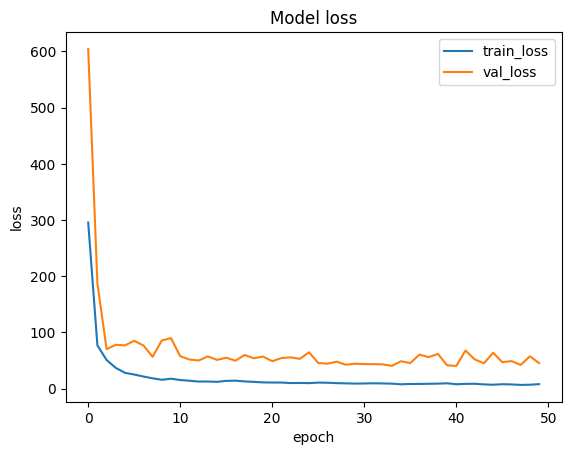

In [35]:
# Plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.show()